#### In this notebook we are going to explore the different varaibles of the dataset, with a main focus in time series and sales, as it is the goal. To do so, we have taken as example 1 shop from CA, out of 10 possibilities. Therefore our analysis will start from the store stage and also will go thought category stage, deparment and a bit on base stage (the individual products)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

import gc

import dask
import dask.dataframe as dd
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

In [2]:
cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:40145 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 16.66 GB


## Load & Check

In [3]:
#we will use 1 of the shops as an example for the EDA and structure
pd.set_option('display.max_columns', None)

df = dd.read_csv("OUTPUT/d_df_CA_1.csv").drop(columns=["Unnamed: 0"])
print(len(df),",",len(df.columns))
df.head()

6003481 , 22


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.46
1,HOBBIES_1_011_CA_1_evaluation,HOBBIES_1_011,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN
2,HOBBIES_1_024_CA_1_evaluation,HOBBIES_1_024,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN
3,HOBBIES_1_030_CA_1_evaluation,HOBBIES_1_030,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN
4,HOBBIES_1_031_CA_1_evaluation,HOBBIES_1_031,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,NaN


In [4]:
df.isnull().sum().compute()

id                    0
item_id               0
dept_id               0
cat_id                0
store_id              0
state_id              0
d                     0
sales                 0
date                  0
wm_yr_wk              0
weekday               0
wday                  0
month                 0
year                  0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
sell_price      1129842
dtype: int64

In [5]:
df.sell_price = df.sell_price.fillna(0)

In [6]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 22 entries, id to sell_price
dtypes: object(13), float64(1), int64(8)

## Downcasting

In [7]:
df.date = dd.to_datetime(df.date)

In [8]:
df = df.compute()

In [9]:
from skmem import MemReducer

mr = MemReducer()

df = mr.fit_transform(df)

Memory in: 5037.61 MB
Starting integers.
Starting objects.
Memory out: 287.08 MB
Reduction: 94.3%


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6003481 entries, 0 to 225060
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   sales         uint16        
 8   date          datetime64[ns]
 9   wm_yr_wk      uint16        
 10  weekday       category      
 11  wday          uint8         
 12  month         uint8         
 13  year          uint16        
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       uint8         
 19  snap_TX       uint8         
 20  snap_WI       uint8         
 21  sell_price    float64       
dtypes: category(12), datetime64[ns](1), float64(1), uint16(3), uint8(5)

## EDA

##### Converting the date column to the index will help us to move easier throught the dataset

In [11]:
df.set_index("date", drop=False, inplace=True)
df.index.names = ["date_index"]

In [12]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
date_index,,,,,,,,,,,,,,,,,,,,,,
2011-01-30,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,d_2,15,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.46
2011-01-30,HOBBIES_1_011_CA_1_evaluation,HOBBIES_1_011,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00
2011-01-30,HOBBIES_1_024_CA_1_evaluation,HOBBIES_1_024,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00
2011-01-30,HOBBIES_1_030_CA_1_evaluation,HOBBIES_1_030,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00
2011-01-30,HOBBIES_1_031_CA_1_evaluation,HOBBIES_1_031,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,2,1,2011,no event,no event,no event,no event,0,0,0,0.00


##### Checking the freq

In [13]:
#normally the freq would be set to "D" or other type, however now is not possible because the dataset cannot
#be reindexed as the index is repeated many times
df.index

DatetimeIndex(['2011-01-30', '2011-01-30', '2011-01-30', '2011-01-30',
               '2011-01-30', '2011-01-30', '2011-01-30', '2011-01-30',
               '2011-01-30', '2011-01-30',
               ...
               '2016-06-19', '2016-06-19', '2016-06-19', '2016-06-19',
               '2016-06-19', '2016-06-19', '2016-06-19', '2016-06-19',
               '2016-06-19', '2016-06-19'],
              dtype='datetime64[ns]', name='date_index', length=6003481, freq=None)

### Plotting Categories 

In [14]:
cats = df.cat_id.value_counts()
cats

FOODS        2829453
HOUSEHOLD    2061543
HOBBIES      1112485
Name: cat_id, dtype: int64

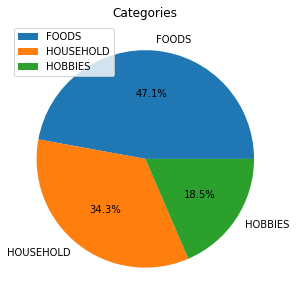

In [15]:
plt.figure(figsize=(15,5))
plt.pie(cats, labels=cats.keys(), autopct="%1.1f%%")
plt.legend(loc=2)
plt.title("Categories")
plt.show()

In [16]:
depts = df.dept_id.value_counts()
depts

FOODS_3        1620487
HOUSEHOLD_1    1047508
HOUSEHOLD_2    1014035
HOBBIES_1       819104
FOODS_2         783662
FOODS_1         425304
HOBBIES_2       293381
Name: dept_id, dtype: int64

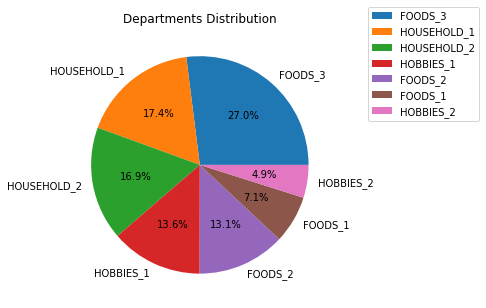

In [17]:
plt.figure(figsize=(15,5))
plt.pie(depts, labels=depts.keys(), autopct="%1.1f%%")
plt.legend(loc="best", bbox_to_anchor=(1.1, 1.1, 0, 0))
plt.title("Departments Distribution")
plt.show()

In [18]:
event1 = df.event_type_1.value_counts()
event1

no event     5509543
Religious     167695
National      158548
Cultural      112813
Sporting       54882
Name: event_type_1, dtype: int64

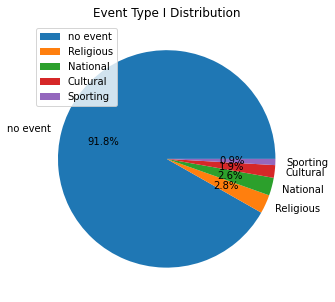

In [19]:
plt.figure(figsize=(15,5))
plt.pie(event1, labels=event1.keys(), autopct="%1.1f%%")
plt.legend(loc=2)
plt.title("Event Type I Distribution")
plt.show()

In [20]:
event2 = df.event_type_2.value_counts()
event2

no event     5988236
Cultural       12196
Religious       3049
Name: event_type_2, dtype: int64

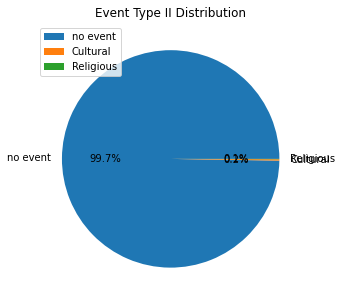

In [21]:
plt.figure(figsize=(15,5))
plt.pie(event2, labels=event2.keys(), autopct="%1.1f%%")
plt.legend(loc=2)
plt.title("Event Type II Distribution")
plt.show()

In [22]:
snap = df.snap_CA.value_counts()
snap

0    4021631
1    1981850
Name: snap_CA, dtype: int64

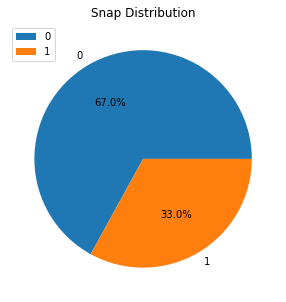

In [23]:
plt.figure(figsize=(15,5))
plt.pie(snap, labels=snap.keys(), autopct="%1.1f%%")
plt.legend(loc=2)
plt.title("Snap Distribution")
plt.show()

#### This section allowed us to see the distribution of each exogeneus category 

### Correlation

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6003481 entries, 2011-01-30 to 2016-06-19
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   sales         uint16        
 8   date          datetime64[ns]
 9   wm_yr_wk      uint16        
 10  weekday       category      
 11  wday          uint8         
 12  month         uint8         
 13  year          uint16        
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       uint8         
 19  snap_TX       uint8         
 20  snap_WI       uint8         
 21  sell_price    float64       
dtypes: category(12), datetime64[ns](1), float64(1), uin

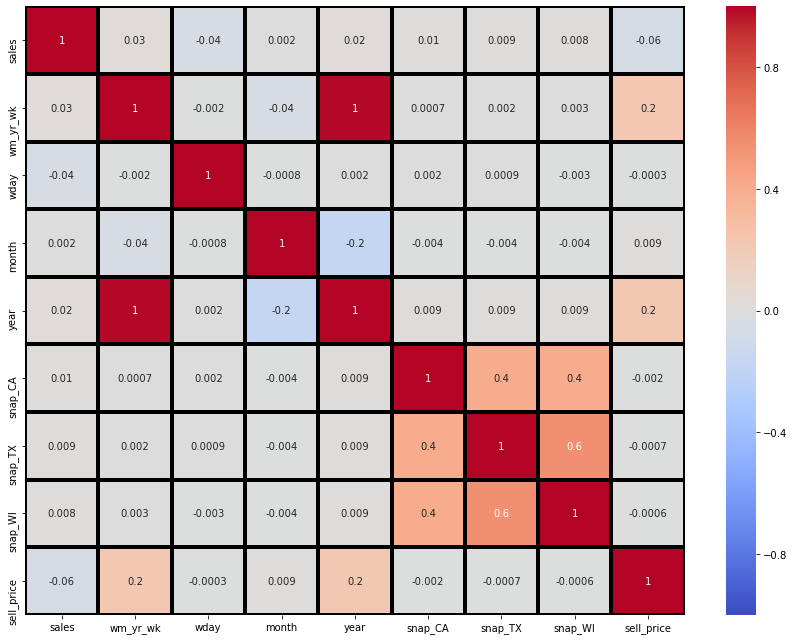

In [25]:
plt.figure(figsize=(12,9))

sns.heatmap(df.select_dtypes(exclude=["category"]).corr(), 
            annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' , linewidths=3, linecolor='black')

plt.tight_layout()
plt.show()

##### This corr plot was made to check if any numerical variable could be influencing the variation of sales during time. However we can see that is not the case

### Sales vs Categories

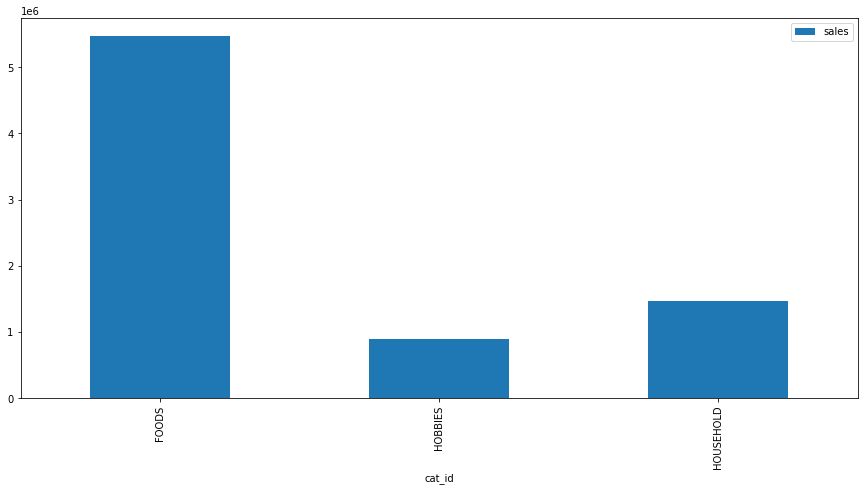

In [26]:
df.groupby("cat_id").agg({"sales":"sum"}).plot.bar(figsize=(15,7))
plt.show()

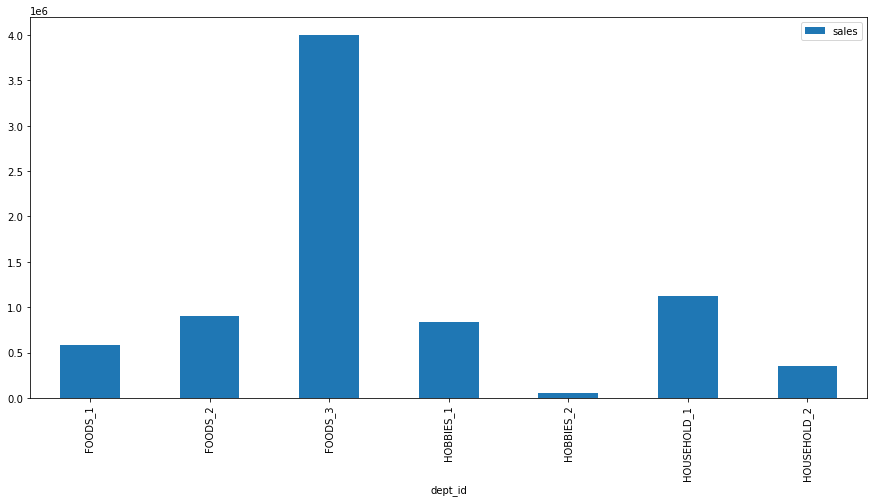

In [27]:
df.groupby("dept_id").agg({"sales":"sum"}).plot.bar(figsize=(15,7))
plt.show()

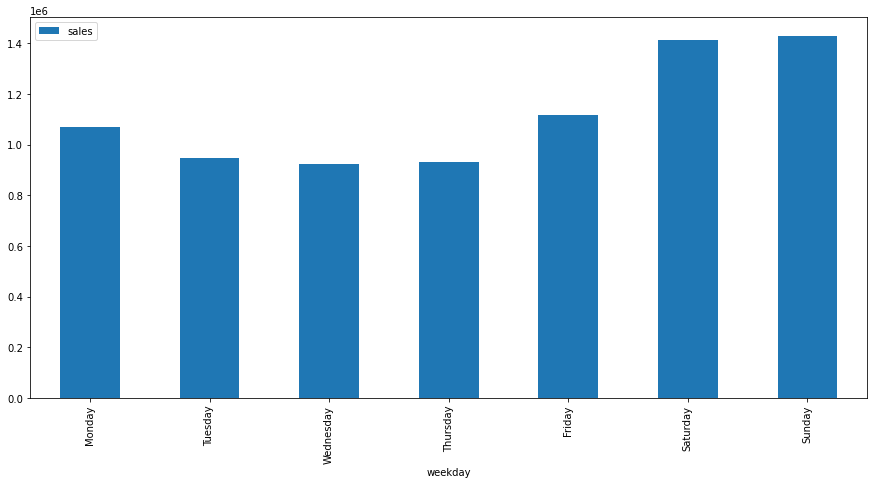

In [28]:
#weekdays wasn't plotted before because the distribution is equal for all as the index freq = "D"
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby("weekday").agg({"sales":"sum"}).reindex(weekdays).plot.bar(figsize=(15,7))
plt.show()

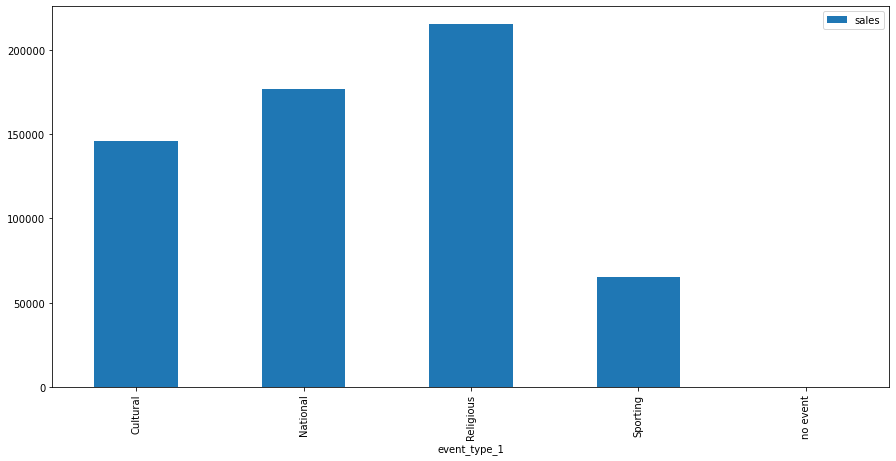

In [29]:
#"no event" has been excluded to take a clearer view of the sales per type of event
df.loc[df.event_type_1!="no event"].groupby("event_type_1").agg({"sales":"sum"}).plot.bar(figsize=(15,7))
plt.legend()
plt.show()

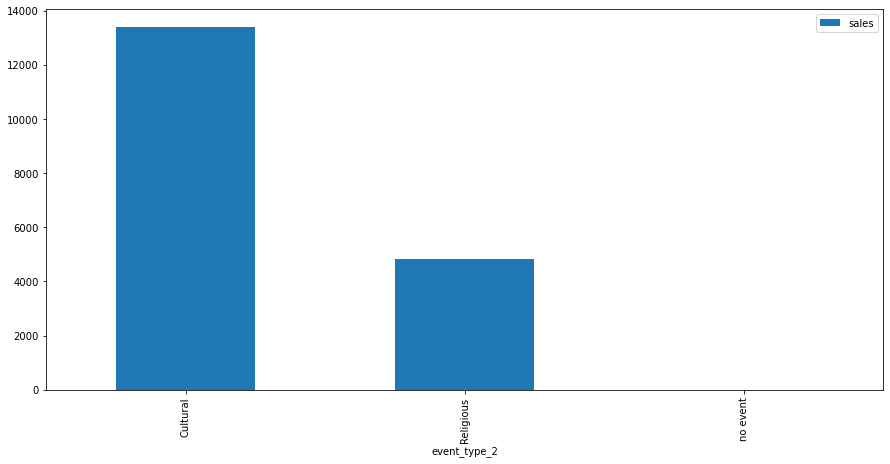

In [30]:
df.loc[df.event_type_2!="no event"].groupby("event_type_2").agg({"sales":"sum"}).plot.bar(figsize=(15,7))
plt.legend()
plt.show()

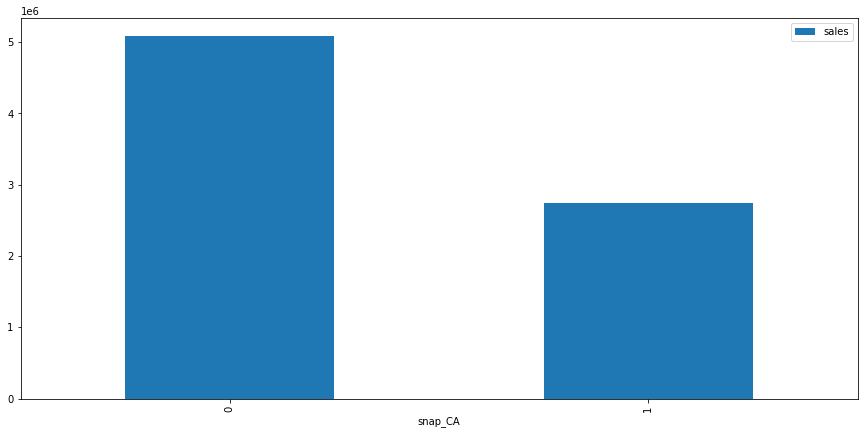

In [31]:
df.groupby("snap_CA").agg({"sales":"sum"}).plot.bar(figsize=(15,7))
plt.show()

#### This section was made with the purpose of seeing the differences between the distribution of each exogeneus variable and their amount of sales during time. Some points that we can highlight is the big difference of sales of the "FOODS" category, as the distribution was similar to "HOUSEHOLDS", it is surprinsing how different they perform in terms of sales 

## Checking Series - Sales

In [32]:
df_day = df.groupby(df.index).agg({"sales":"sum"}).asfreq(freq="D")
df_week = df.groupby(df.index).agg({"sales":"sum"}).rolling(7).mean()
df_year = df.groupby(df.index).agg({"sales":"sum"}).rolling(365).mean()

### Trend vs Periodicity

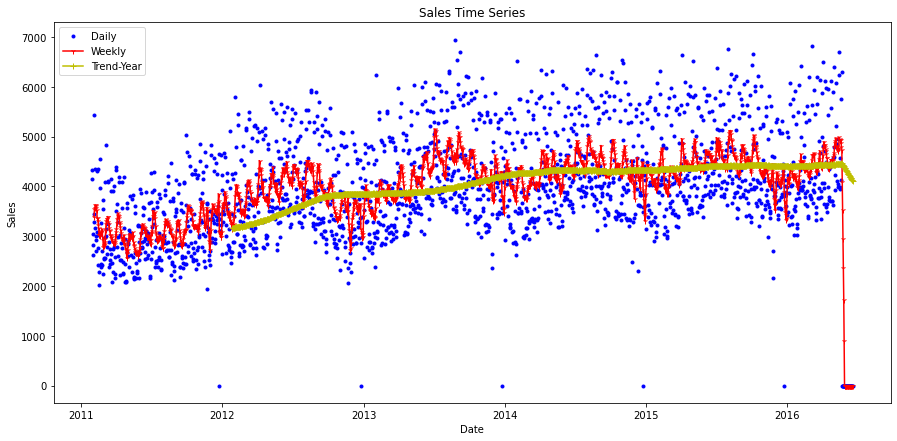

In [33]:
f, ax = plt.subplots(figsize=(15,7))

ax.plot(df_day, marker=".", color="b", label="Daily", linestyle="None")

ax.plot(df_week, marker="1", color="r", label="Weekly", linestyle="-")

ax.plot(df_year, marker="+", color="y", label="Trend-Year", linestyle="-")

ax.set_title("Sales Time Series")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
plt.show()

### Sales per Category

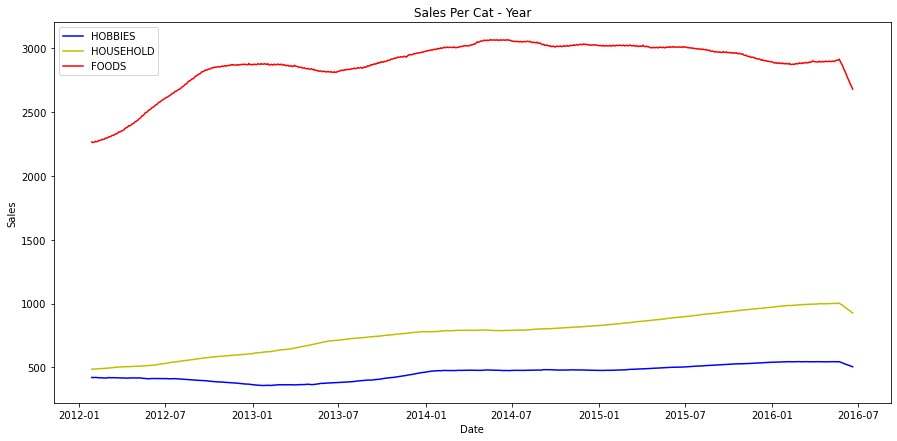

In [34]:
cdict = {
    "HOBBIES":"b",
    "HOUSEHOLD":"y",
    "FOODS":"r"
}

f, ax = plt.subplots(figsize=(15,7))

for c, co in zip(df.cat_id.unique(), cdict.values()):
    ax.plot(df[df.cat_id==c].groupby("date").agg({"sales":"sum"}).rolling(365).mean(), color=co, label=c, linestyle="-")
    ax.set_title("Sales Per Cat - Year")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
plt.show()

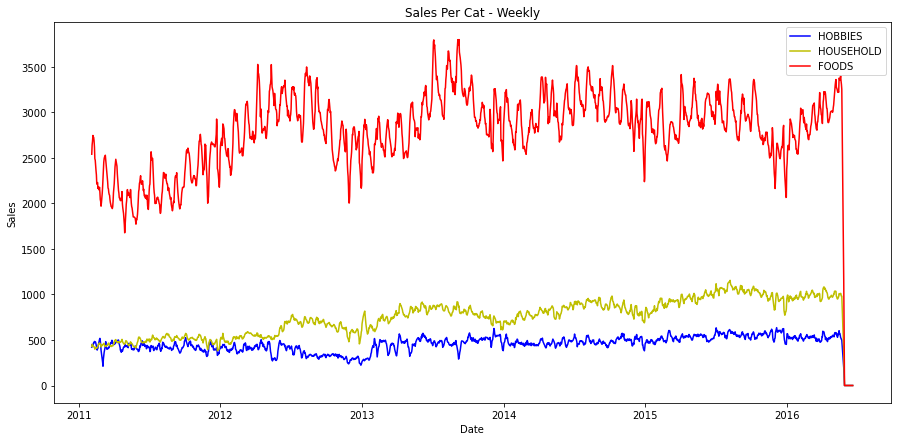

In [35]:
f, ax = plt.subplots(figsize=(15,7))

for c, co in zip(df.cat_id.unique(), cdict.values()):
    ax.plot(df[df.cat_id==c].groupby("date").agg({"sales":"sum"}).rolling(7).mean(), color=co, label=c, linestyle="-")
    ax.set_title("Sales Per Cat - Weekly")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
plt.show()

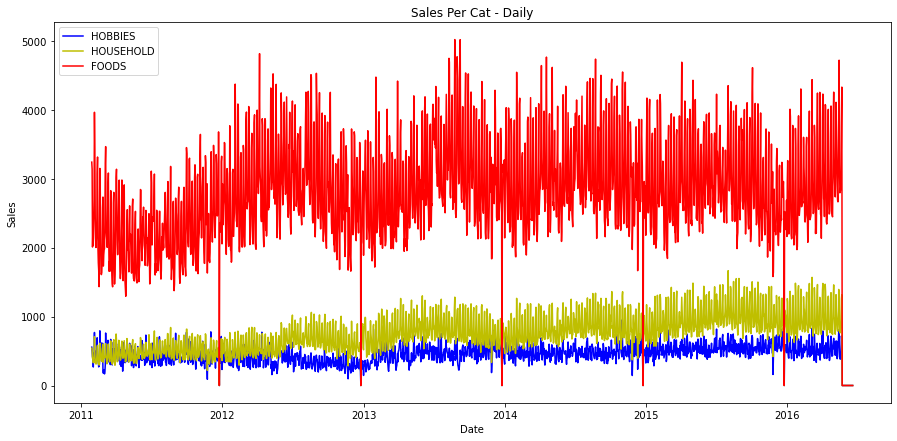

In [36]:
f, ax = plt.subplots(figsize=(15,7))

for c, co in zip(df.cat_id.unique(), cdict.values()):
    ax.plot(df[df.cat_id==c].groupby("date").agg({"sales":"sum"}), color=co, label=c, linestyle="-")
    ax.set_title("Sales Per Cat - Daily")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
plt.show()

### Sales per Department

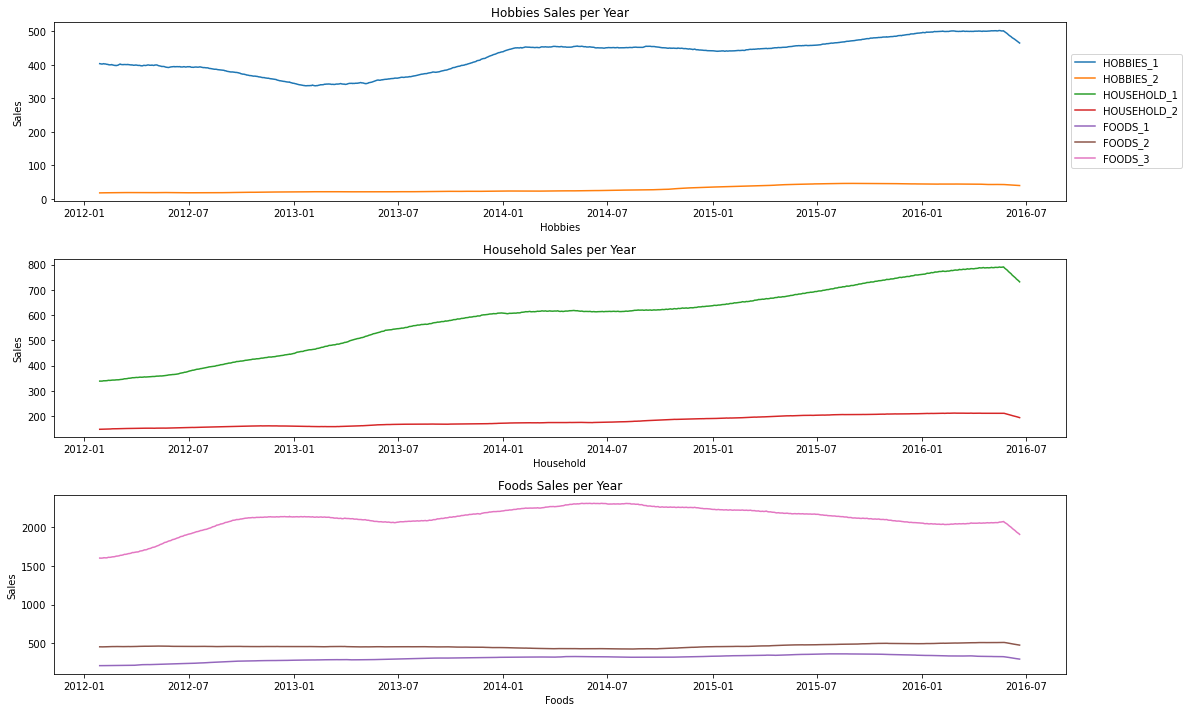

In [37]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))

for d in (df.dept_id.unique()):
    ax1.plot(df[(df.cat_id=="HOBBIES")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}).rolling(365).mean(), label=d, linestyle="-")
    ax1.set_ylabel("Sales")
    ax1.set_xlabel("Hobbies")
    ax1.set_title("Hobbies Sales per Year")
    
    ax2.plot(df[(df.cat_id=="HOUSEHOLD")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}).rolling(365).mean(), label=d, linestyle="-")
    ax2.set_ylabel("Sales")
    ax2.set_xlabel("Household")
    ax2.set_title("Household Sales per Year")
    
    ax3.plot(df[(df.cat_id=="FOODS")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}).rolling(365).mean(), label=d, linestyle="-")    
    ax3.set_ylabel("Sales")
    ax3.set_xlabel("Foods")
    ax3.set_title("Foods Sales per Year")
    
f.tight_layout()
plt.legend(loc="best", bbox_to_anchor=(1.12, 3.5, 0, 0))
plt.show()

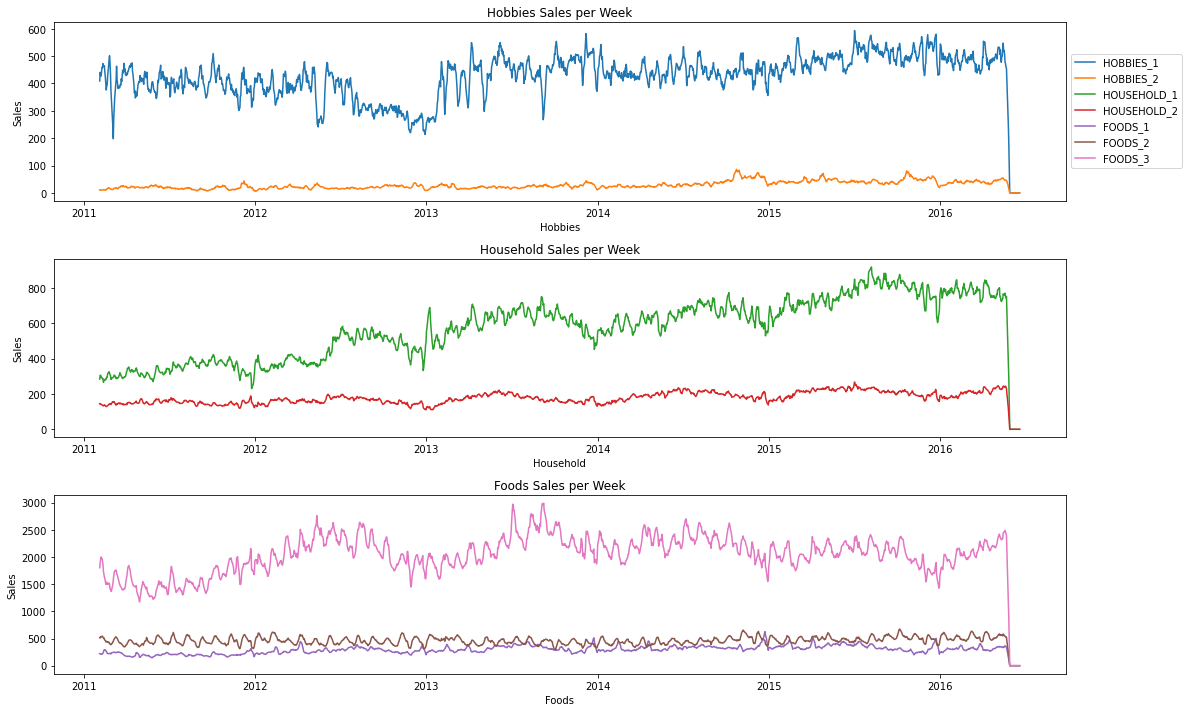

In [38]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))

for d in (df.dept_id.unique()):
    ax1.plot(df[(df.cat_id=="HOBBIES")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}).rolling(7).mean(), label=d, linestyle="-")
    ax1.set_ylabel("Sales")
    ax1.set_xlabel("Hobbies")
    ax1.set_title("Hobbies Sales per Week")
    
    ax2.plot(df[(df.cat_id=="HOUSEHOLD")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}).rolling(7).mean(), label=d, linestyle="-")
    ax2.set_ylabel("Sales")
    ax2.set_xlabel("Household")
    ax2.set_title("Household Sales per Week")
    
    ax3.plot(df[(df.cat_id=="FOODS")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}).rolling(7).mean(), label=d, linestyle="-")    
    ax3.set_ylabel("Sales")
    ax3.set_xlabel("Foods")
    ax3.set_title("Foods Sales per Week")
    
f.tight_layout()
plt.legend(loc="best", bbox_to_anchor=(1.12, 3.5, 0, 0))
plt.show()

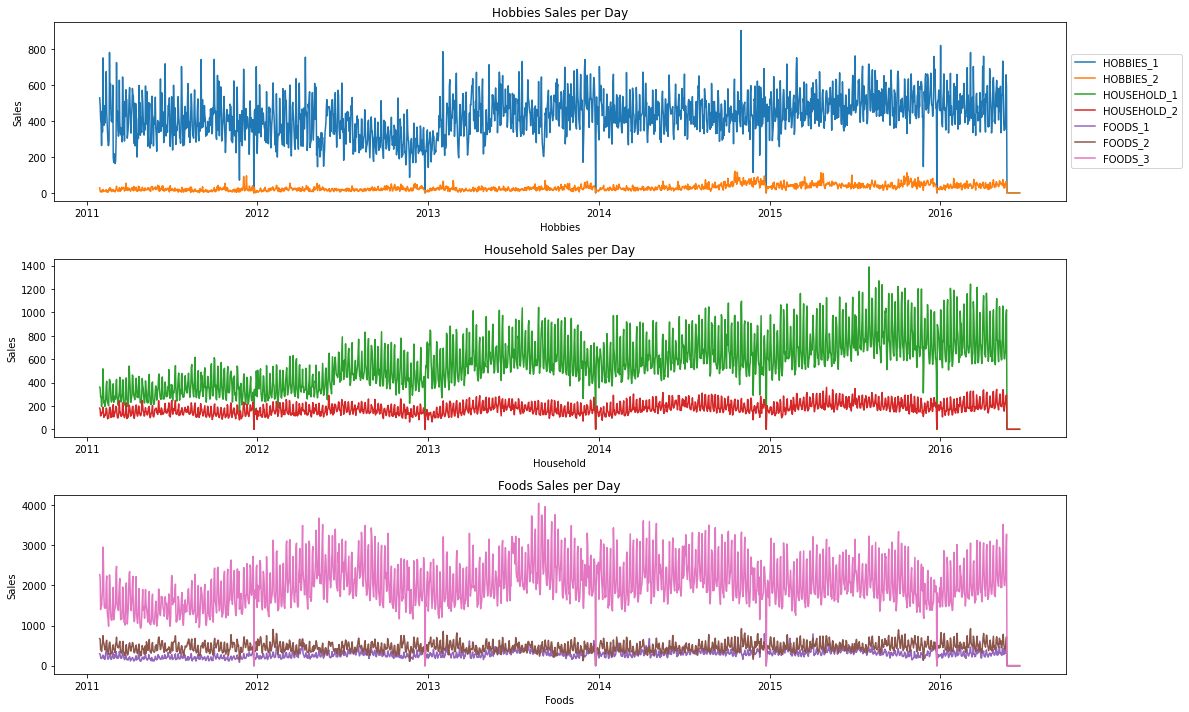

In [39]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))

for d in (df.dept_id.unique()):
    ax1.plot(df[(df.cat_id=="HOBBIES")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}), label=d, linestyle="-")
    ax1.set_ylabel("Sales")
    ax1.set_xlabel("Hobbies")
    ax1.set_title("Hobbies Sales per Day")
    
    ax2.plot(df[(df.cat_id=="HOUSEHOLD")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}), label=d, linestyle="-")
    ax2.set_ylabel("Sales")
    ax2.set_xlabel("Household")
    ax2.set_title("Household Sales per Day")
    
    ax3.plot(df[(df.cat_id=="FOODS")&(df.dept_id==d)].groupby("date").agg({"sales":"sum"}), label=d, linestyle="-")    
    ax3.set_ylabel("Sales")
    ax3.set_xlabel("Foods")
    ax3.set_title("Foods Sales per Day")
    
f.tight_layout()
plt.legend(loc="best", bbox_to_anchor=(1.12, 3.5, 0, 0))
plt.show()

### Sales per Product (just the 1st 9)

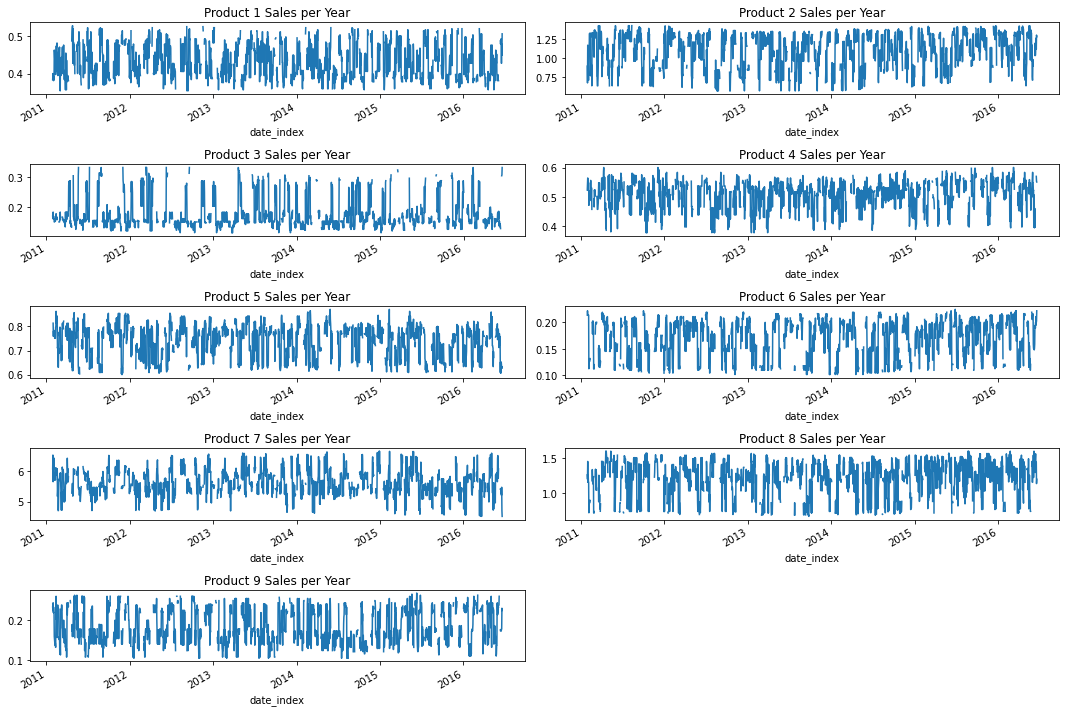

In [40]:
f = plt.figure(figsize=(15,10))

for n in range(1,10):
    ax = f.add_subplot(5,2, n)
    df[df.item_id==f"FOODS_3_00{n}"]["sales"].rolling(365).mean().plot(ax=ax)
    ax.set_title(f"Product {n} Sales per Year")
plt.tight_layout()
plt.show()

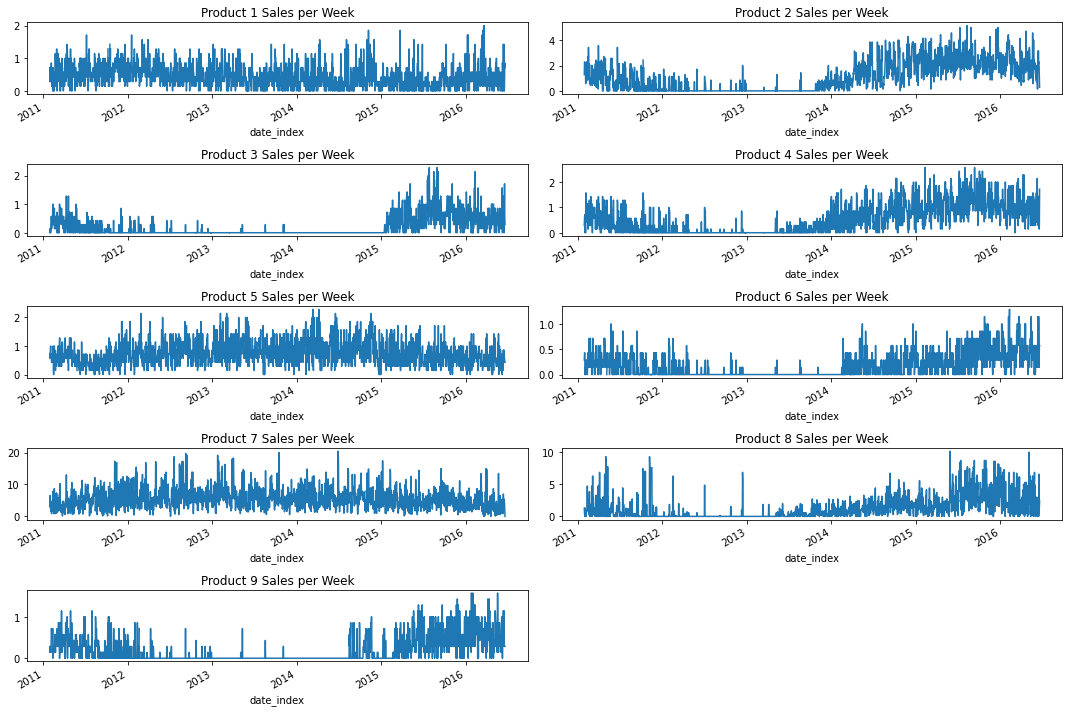

In [41]:
f = plt.figure(figsize=(15,10))

for n in range(1,10):
    ax = f.add_subplot(5,2, n)
    df[df.item_id==f"FOODS_3_00{n}"]["sales"].rolling(7).mean().plot(ax=ax)
    ax.set_title(f"Product {n} Sales per Week")
plt.tight_layout()
plt.show()

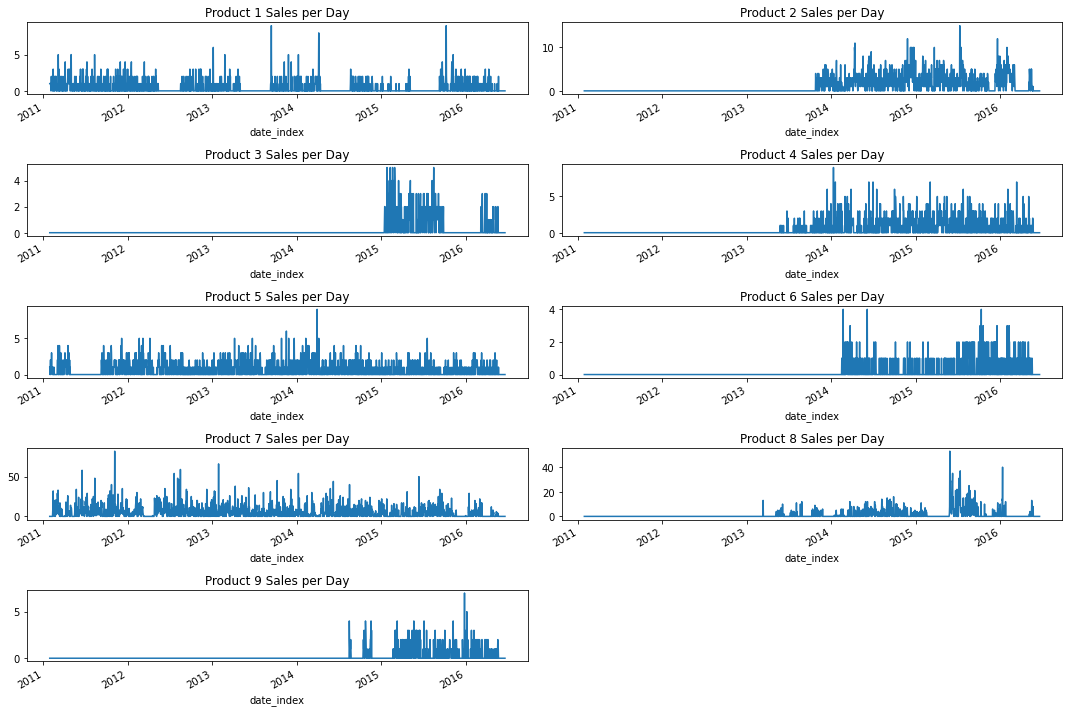

In [42]:
f = plt.figure(figsize=(15,10))

for n in range(1,10):
    ax = f.add_subplot(5,2, n)
    df[df.item_id==f"FOODS_3_00{n}"]["sales"].plot(ax=ax)
    ax.set_title(f"Product {n} Sales per Day")
plt.tight_layout()
plt.show()

#### The purspose of the previous section was to disaggregate each is step inside the hierarchy sales to have a better idea of how the sales of each group works. Conclusions:
    1. Until the departments step most of the sales groups are stationary, except for Hobbies_1 and Household_1 which have a seasonal variance and positive trend respectively
    2. The last step, the sales of each individual product (our goal), seems to be completly independent of the deparment at day level, category or even store (the step where we start from). Which means that making predictions in a level different than the base level won't have good results

## Pre Fiting Observations

### Seasonal Decompose

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

dec = seasonal_decompose(df_day, model="additive", extrapolate_trend="freq")
df_dec = pd.concat([dec.seasonal, dec.trend, dec.resid, dec.observed], axis=1).rename(columns={0:"original"})
df_dec.head()

,seasonal,trend,resid,original
date_index,,,,
2011-01-29,1034.386982,3400.030612,-97.417594,4337.0
2011-01-30,1101.031377,3427.025510,-373.056887,4155.0
2011-01-31,-172.611945,3454.020408,-465.408463,2816.0
2011-02-01,-609.017567,3387.857143,272.160424,3051.0
2011-02-02,-696.616957,3545.000000,-218.383043,2630.0


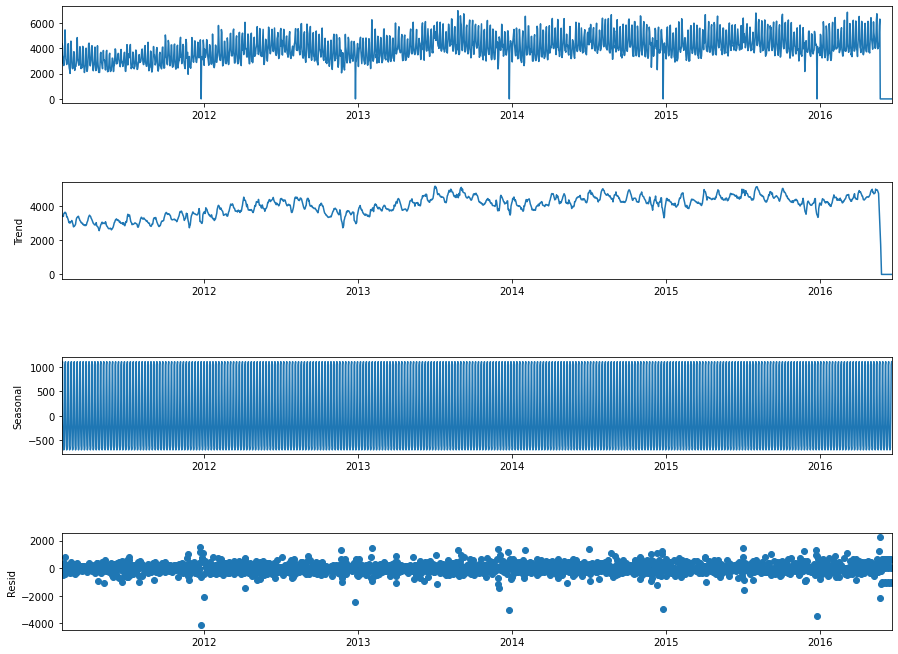

In [44]:
dec.plot().set_size_inches(14, 10)

#### This graph doesn't tell us anything new, except for the residuals, which can be considered as outliers and we will consider to exclude them for our different models.

#### Adfuller Test

In [45]:
from statsmodels.tsa.stattools import adfuller

In [46]:
print("p-value:", adfuller(df_day)[1])

p-value: 0.8902376361977319


#### Adfuller test assumes the result is non stationary, that is h0. Therefore as p-value > 0.05 we cannot reject h0, so our time series is not stationary. What can we do to make it stationary? We can use the diff() formula from pandas to exclude the trend

#### Setting Diff

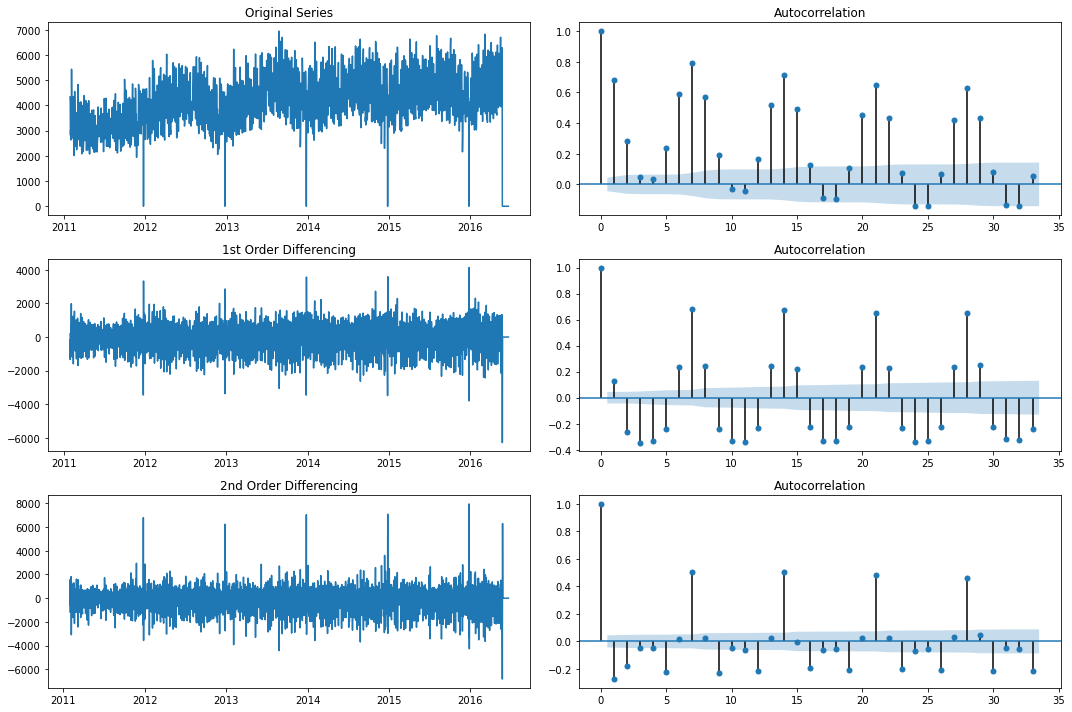

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes[0, 0].plot(df_day)
axes[0, 0].set_title('Original Series')
plot_acf(df_day, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_day.astype("int").diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_day.astype("int").diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_day.astype("int").diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_day.astype("int").diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

#### Looking the previous graphs we can see with difference = 1, the autocorrelation is fairer in both sides of the line and also it doesn't go to the negative part until the two days, so we will set d = 1

In [48]:
print("p-value:", adfuller(df_day.astype("int").diff().dropna())[1])

p-value: 3.1378686608675663e-27


#### Now our model is stationary lets find the perfect numbers for Auto Regression and Moving Average

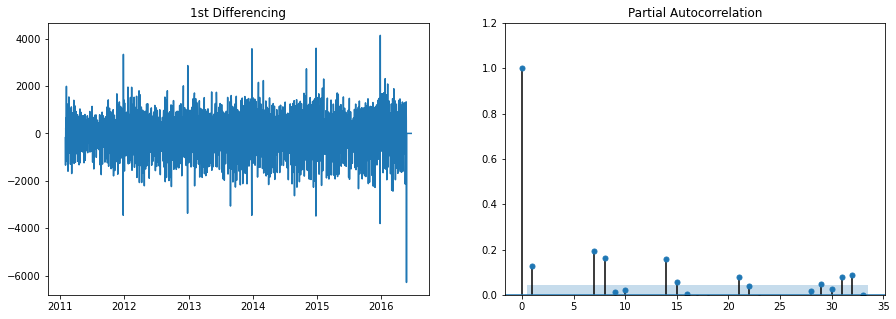

In [49]:
# Setting AR
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(df_day.astype("int").diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_pacf(df_day.astype("int").diff().dropna(), ax=axes[1])

plt.show()

#### To pick the perfect number for AR we use the partial autocorrelation graph, which is similar to the autocorrelation, but excluding some lags in between. Normally the picked number is equal to the sum of number of lags that, at the beginning of the graph, are significative, that is, over the blue shadow. In this case would be 2

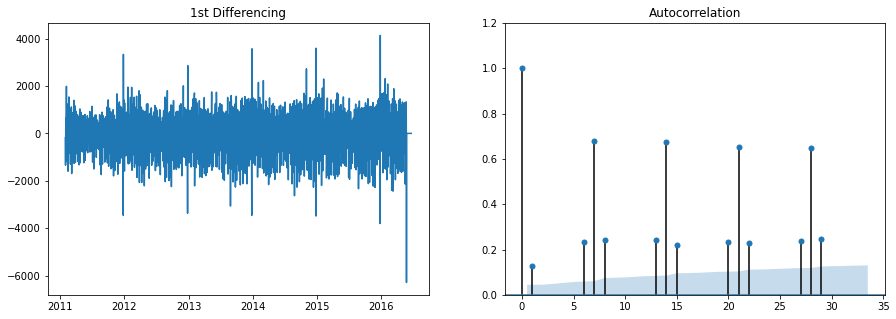

In [50]:
# Setting MA
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(df_day.astype("int").diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_day.astype("int").diff().dropna(), ax=axes[1])

plt.show()

#### With the MA, we follow a different approach than with AR, we must take into account all the lags that are far away the blue shadow, not just the ones at the beginning

### Preparing Data

In [51]:
#ENDOGENEUS VARS
y_train = df.groupby(df.index).agg({"sales":"sum"})[:"2016-04-25"]
y_test = df.groupby(df.index).agg({"sales":"sum"})["2016-04-25":"2016-05-22"]

#casting as float for ARIMA
y_train = y_train.astype("float")
y_test = y_test.astype("float")

#EXOGENEOUS VARS
exo_train = pd.get_dummies(df[["date", "wday", "snap_CA", "sell_price"]]).groupby(["date", "wday", "snap_CA"]).agg({"sell_price":"mean"}).reset_index(level=["wday", "snap_CA"])[:"2016-04-25"]
exo_test = pd.get_dummies(df[["date", "wday", "snap_CA", "sell_price"]]).groupby(["date", "wday", "snap_CA"]).agg({"sell_price":"mean"}).reset_index(level=["wday", "snap_CA"])["2016-04-25":"2016-05-22"]

### ARIMAX

In [152]:
from statsmodels.tsa.arima_model import ARIMA 

model = ARIMA(endog=y_train, order=(2, 1, 5), exog=exo_train, freq="D")

fitted = model.fit(trend="nc", maxiter=2000, disp=0)

print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1913
Model:                 ARIMA(2, 1, 5)   Log Likelihood              -14569.040
Method:                       css-mle   S.D. of innovations            490.053
Date:                Tue, 30 Jun 2020   AIC                          29160.080
Time:                        16:28:33   BIC                          29221.201
Sample:                    01-30-2011   HQIC                         29182.573
                         - 04-25-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
wday             -3.2386      1.010     -3.207      0.001      -5.218      -1.260
snap_CA          39.9591      6.598      6.056      0.000      27.027      52.892
sell_price        0.0740      0.928     

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/diego/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


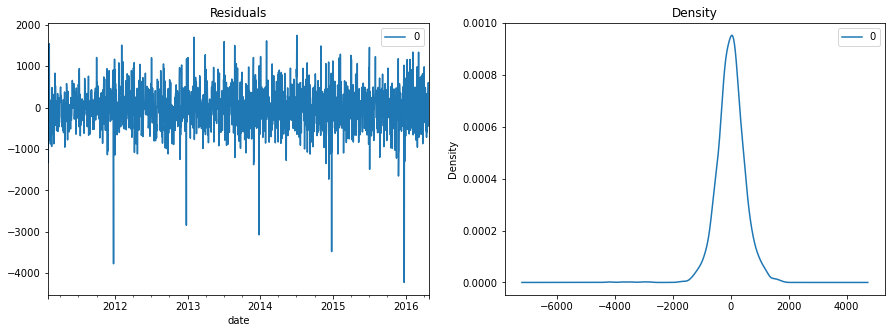

In [153]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

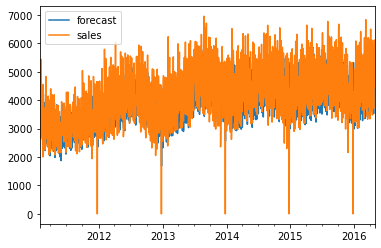

In [154]:
fitted.plot_predict(dynamic=False, alpha=.2)
plt.show()

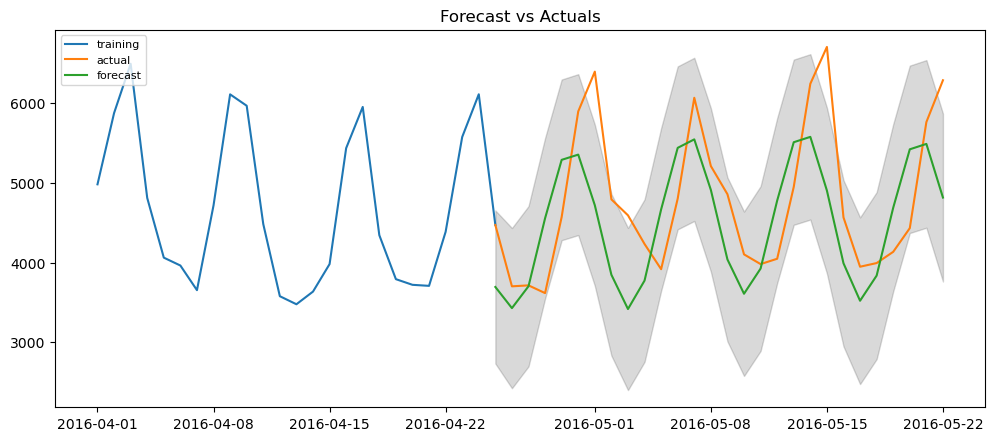

In [155]:
# ARIMAX
# Forecast
fc, se, conf = fitted.forecast(28, alpha=0.05, exog=exo_test)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=y_test.index)
lower_series = pd.Series(conf[:, 0], index=y_test.index)
upper_series = pd.Series(conf[:, 1], index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### SARIMAX

In [56]:
exo_train_s = pd.get_dummies(df[["date", "wday", "snap_CA", "sell_price"]]).groupby(["date", "wday", "snap_CA"]).agg({"sell_price":"mean"}).reset_index(level=["wday", "snap_CA"])[:"2016-04-25"]
exo_test_s = pd.get_dummies(df[["date", "wday", "snap_CA", "sell_price"]]).groupby(["date", "wday", "snap_CA"]).agg({"sell_price":"mean"}).reset_index(level=["wday", "snap_CA"])["2016-04-25":"2016-05-22"]

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

model_s = SARIMAX(endog=y_train, order=(2, 1, 5), seasonal_order=(0, 1, 0, 12), exog=exo_train_s, freq="D")

fitted_s = model_s.fit(trend="nc", maxiter=2000, disp=0)

print(fitted_s.summary())

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1914
Model:             SARIMAX(2, 1, 5)x(0, 1, [], 12)   Log Likelihood              -14878.885
Date:                             Tue, 30 Jun 2020   AIC                          29779.770
Time:                                     12:14:26   BIC                          29840.822
Sample:                                 01-29-2011   HQIC                         29802.245
                                      - 04-25-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
wday        -165.6837      8.299    -19.964      0.000    -181.950    -149.418
snap_CA      353.0328     2

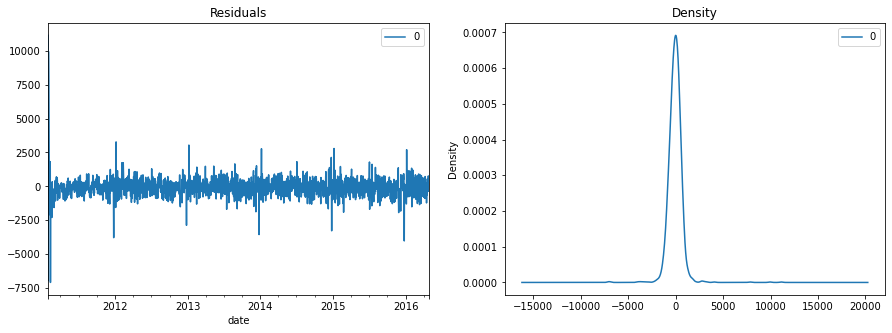

In [58]:
residuals = pd.DataFrame(fitted_s.resid)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

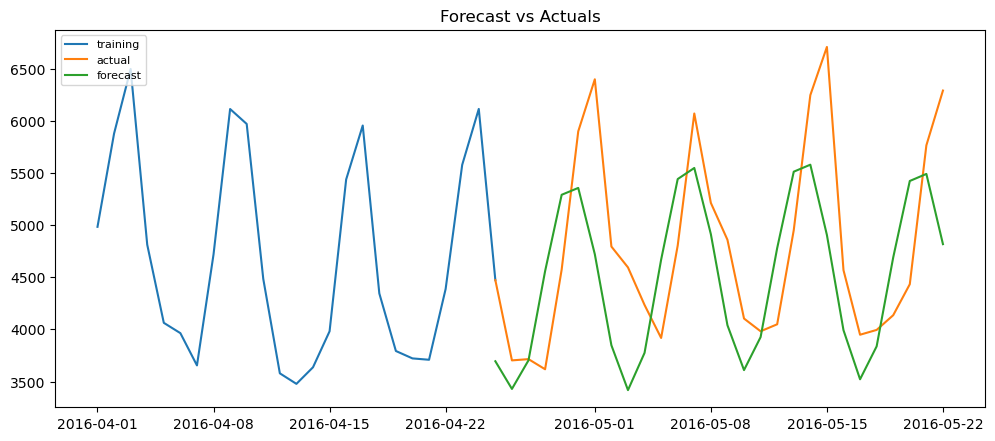

In [59]:
# SARIMAX
# Forecast
forecast = fitted_s.forecast(28, alpha=0.05, exog=exo_test_s)  # 95% conf

# Make as pandas series
forecast_series = pd.Series(fc, index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(forecast_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### AUTO-ARIMA

In [60]:
from pmdarima.arima import auto_arima

model_au_ar = auto_arima(y=y_train, exogenous=exo_train_s, start_p=2, d=1, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, 
                         D=1, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=12, seasonal=True, 
                         stationary=False, information_criterion='aic', alpha=0.05, test='adf', 
                         seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, 
                         method='lbfgs', maxiter=1000, offset_test_args=None, seasonal_test_args=None, 
                         suppress_warnings=True, error_action='ignore', trace=True, random=False, 
                         random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse')

print(model_au_ar.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,1,1,12) [intercept=True]; AIC=30034.671, BIC=30095.723, Time=29.207 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=31787.905, BIC=31815.656, Time=0.188 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=31647.134, BIC=31685.985, Time=6.724 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=30288.361, BIC=30327.211, Time=13.965 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=31785.911, BIC=31808.112, Time=1.095 seconds
Fit ARIMA(2,1,2)x(0,1,1,12) [intercept=True]; AIC=30036.265, BIC=30091.767, Time=22.690 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,1,2)x(1,1,0,12) [intercept=True]; AIC=30905.353, BIC=

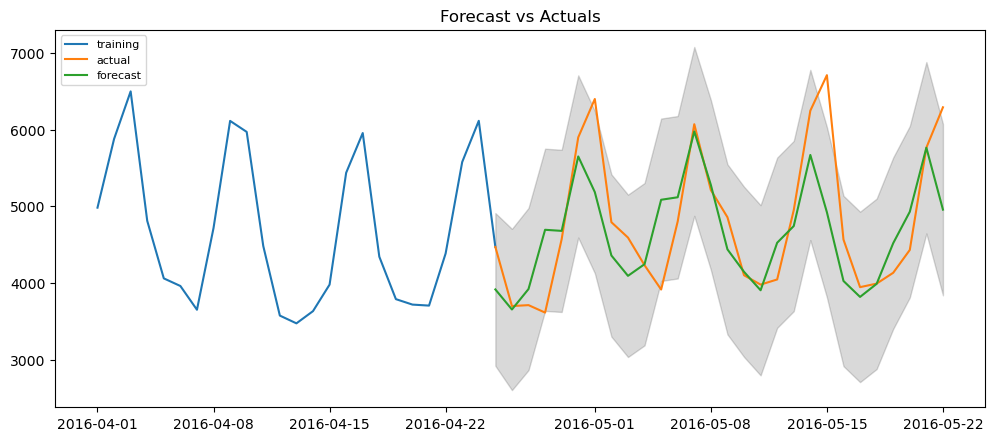

In [61]:
# AUTO-ARIMA
# Forecast
auto_fc, confint = model_au_ar.predict(n_periods=28, return_conf_int=True, exogenous=exo_test_s)

# Make as pandas series
au_fc_series = pd.Series(auto_fc, index=y_test.index)
au_lower_series = pd.Series(confint[:, 0], index=y_test.index)
au_upper_series = pd.Series(confint[:, 1], index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(au_fc_series, label='forecast')
plt.fill_between(au_lower_series.index, au_lower_series, au_upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### AUTO-ARIMA FOURIER FIT

In [62]:
from pmdarima import pipeline, preprocessing as ppc, arima

pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe_fitted = pipe.fit(y_train, exogenous=exo_train_s)
print("Model fit:")
print(pipe_fitted.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=30120.717, BIC=30215.176, Time=6.031 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=30784.160, BIC=30856.393, Time=0.203 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=30752.920, BIC=30830.710, Time=1.489 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=30354.616, BIC=30432.406, Time=4.251 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=30782.193, BIC=30848.870, Time=1.734 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=30109.760, BIC=30198.663, Time=6.343 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=30135.434, BIC=30218.780, Time=3.759 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=30139.049, BIC=30222.395, Time=6.551 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=29974.551, BIC=30069.010, Time=6.204 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=29986.610, BIC=30075.513, Time=5.887 seconds
Fit ARIMA(2,1,3)

/home/diego/anaconda3/lib/python3.7/site-packages/pmdarima/pipeline.py:451: UserWarning: Inverse transformation on confidence intervals not currently supported, will not inverse transform
  UserWarning)


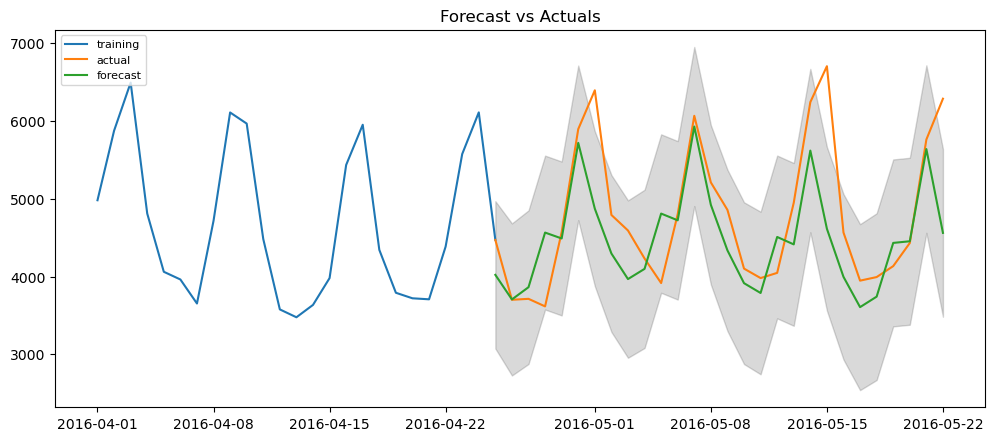

In [63]:
# AUTO-ARIMA
# Forecast
fu_auto_fc, fu_conf_int = pipe_fitted.predict(n_periods=28, return_conf_int=True, exogenous=exo_test_s)

# Make as pandas series
fu_au_fc_series = pd.Series(fu_auto_fc, index=y_test.index)
fu_au_lower_series = pd.Series(fu_conf_int[:, 0], index=y_test.index)
fu_au_upper_series = pd.Series(fu_conf_int[:, 1], index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(fu_au_fc_series, label='forecast')
plt.fill_between(fu_au_lower_series.index, fu_au_lower_series, fu_au_upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### TBATS

In [64]:
from tbats import TBATS

# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))

model_t = estimator.fit(y_train)

# Forecast 365 days ahead
forecast_t = model_t.forecast(steps=28)

In [65]:
print(model_t.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [3 1]
ARMA errors (p, q): (2, 1)
Smoothing (Alpha): 0.045456
Seasonal Parameters (Gamma): [-1.57212058e-05  1.26946169e-06 -3.69161138e-05  1.99934603e-05]
AR coefficients [-3.69161138e-05  1.99934603e-05]
MA coefficients [0.30592449]
Seed vector [3521.52990643  885.87943441  207.56071885  -51.25244149  397.1391182
  226.80436149   52.08882531 -208.95441958   55.26081856    0.
    0.            0.        ]

AIC 37779.641241


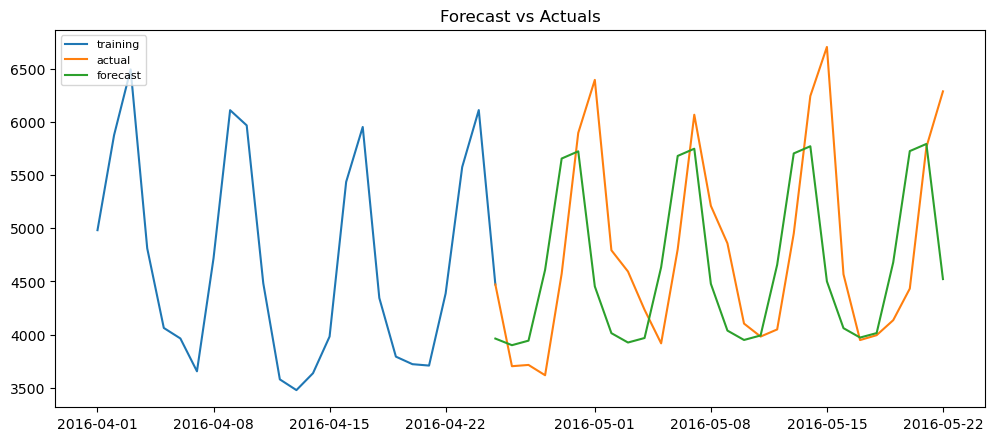

In [66]:
# TBATS

# Make as pandas series with forcasted values
forecast_t = pd.Series(forecast_t, index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(forecast_t, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### FB Prophet

In [94]:
df_fb = y_train[:-1].reset_index()
df_fb.columns = ["ds", "y"]
prediction = 28
df_fb.tail()

,ds,y
1908,2016-04-20,3722.0
1909,2016-04-21,3709.0
1910,2016-04-22,4387.0
1911,2016-04-23,5577.0
1912,2016-04-24,6113.0


In [100]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

m = Prophet()
m.fit(df_fb)

future = m.make_future_dataframe(periods=prediction)

forecast_fb = m.predict(future)
forecast_fb.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,2909.092064,3208.973107,4452.781048,2909.092064,2909.092064,915.132692,915.132692,915.132692,1043.178107,1043.178107,1043.178107,-128.045415,-128.045415,-128.045415,0.0,0.0,0.0,3824.224756
1,2011-01-30,2910.008887,3292.145639,4535.242075,2910.008887,2910.008887,989.631345,989.631345,989.631345,1107.302348,1107.302348,1107.302348,-117.671003,-117.671003,-117.671003,0.0,0.0,0.0,3899.640232
2,2011-01-31,2910.925711,2019.032706,3214.678478,2910.925711,2910.925711,-275.639818,-275.639818,-275.639818,-168.091388,-168.091388,-168.091388,-107.548430,-107.548430,-107.548430,0.0,0.0,0.0,2635.285893
3,2011-02-01,2911.842534,1631.024316,2797.741328,2911.842534,2911.842534,-709.395068,-709.395068,-709.395068,-611.649146,-611.649146,-611.649146,-97.745922,-97.745922,-97.745922,0.0,0.0,0.0,2202.447466
4,2011-02-02,2912.759358,1558.620878,2744.318546,2912.759358,2912.759358,-791.756055,-791.756055,-791.756055,-703.423387,-703.423387,-703.423387,-88.332668,-88.332668,-88.332668,0.0,0.0,0.0,2121.003303


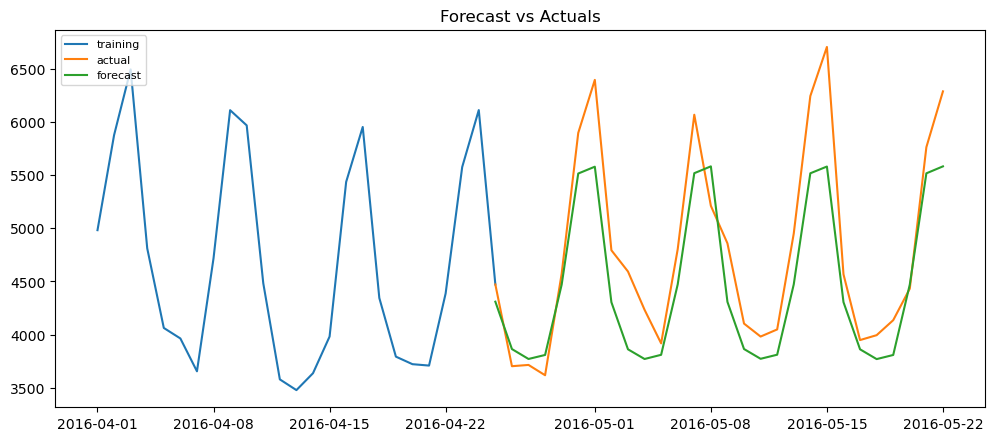

In [109]:
# FB Prophet

# Make as pandas series with forcasted values
forecast_fb = pd.Series(np.array(forecast_fb["yhat"][-28:]), index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(forecast_fb, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### FB Prophet - Box-Cox

In [130]:
from scipy import stats

df_cox = df_fb.set_index("ds")
#box-cox transformation stricly needs vals > 0.0
df_cox[df_cox.y<1] = 0.01
df_cox['y'], lambda_prophet = stats.boxcox(df_cox['y'])
df_cox.reset_index(inplace=True)
df_cox.tail()

,ds,y
1908,2016-04-20,956.966227
1909,2016-04-21,954.257084
1910,2016-04-22,1093.294663
1911,2016-04-23,1327.916054
1912,2016-04-24,1430.374423


In [183]:
m_cox = Prophet()
m_cox.fit(df_cox)

future_cox = m_cox.make_future_dataframe(periods=prediction)

forecast_cox = m_cox.predict(future_cox)
forecast_cox.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,805.137155,861.721687,1116.473515,805.137155,805.137155,184.072689,184.072689,184.072689,212.243825,212.243825,212.243825,-28.171135,-28.171135,-28.171135,0.0,0.0,0.0,989.209845
1,2011-01-30,805.093405,880.942791,1136.983792,805.093405,805.093405,196.891998,196.891998,196.891998,223.412450,223.412450,223.412450,-26.520452,-26.520452,-26.520452,0.0,0.0,0.0,1001.985403
2,2011-01-31,805.049655,617.376523,868.714114,805.049655,805.049655,-56.704345,-56.704345,-56.704345,-31.819338,-31.819338,-31.819338,-24.885008,-24.885008,-24.885008,0.0,0.0,0.0,748.345310
3,2011-02-01,805.005905,536.801733,788.839162,805.005905,805.005905,-148.254706,-148.254706,-148.254706,-124.984135,-124.984135,-124.984135,-23.270572,-23.270572,-23.270572,0.0,0.0,0.0,656.751199
4,2011-02-02,804.962155,510.545685,768.522363,804.962155,804.962155,-166.197914,-166.197914,-166.197914,-144.513395,-144.513395,-144.513395,-21.684519,-21.684519,-21.684519,0.0,0.0,0.0,638.764241


In [184]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_cox[column] = inverse_boxcox(forecast_cox[column], lambda_prophet)

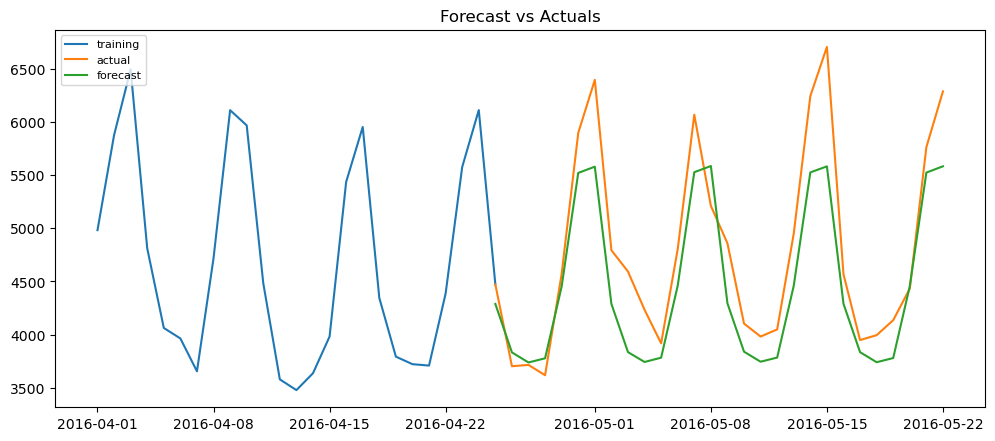

In [185]:
# FB Prophet - BOX-COX

# Make as pandas series with forcasted values
forecast_cox = pd.Series(np.array(forecast_cox["yhat"][-28:]), index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(forecast_cox, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### FB Prophet + Regressors

In [137]:
import utils

In [180]:
df_fb_train = pd.get_dummies(df[["sales", "date", "wday", "snap_CA", "sell_price"]]).groupby(["date", "wday", "snap_CA"]).agg({"sales":"sum", "sell_price":"mean"})[:"2016-04-24"].reset_index().rename(columns={"date": "ds", "sales":"y"})
df_fb_test = pd.get_dummies(df[["sales", "date", "wday", "snap_CA", "sell_price"]]).groupby(["date", "wday", "snap_CA"]).agg({"sales":"sum", "sell_price":"mean"})["2016-04-25":"2016-05-22"].reset_index().rename(columns={"date": "ds", "sales":"y"})

df_fb_train = df_fb_train[["ds", "y", "wday", "snap_CA", "sell_price"]]
df_fb_test = df_fb_test[["ds", "y", "wday", "snap_CA", "sell_price"]]

In [215]:
m_regs = Prophet()
m_regs.add_regressor("wday")
m_regs.add_regressor("snap_CA")
m_regs.add_regressor("sell_price")
    
m_regs.fit(df_fb_train)

future_regs = m_regs.make_future_dataframe(periods=prediction)
future_regs["wday"] = df_fb_train["wday"]
future_regs["snap_CA"] = df_fb_train["snap_CA"]
future_regs["sell_price"] = df_fb_train["wday"]

forecast_regs = m_regs.predict(future_regs[:-28])
forecast_regs.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,sell_price,sell_price_lower,sell_price_upper,snap_CA,snap_CA_lower,snap_CA_upper,wday,wday_lower,wday_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,931.103171,4315.713514,5390.473837,931.103171,931.103171,3915.686575,3915.686575,3915.686575,3607.926086,3607.926086,3607.926086,3087.633582,3087.633582,3087.633582,0.00000,0.00000,0.00000,520.292504,520.292504,520.292504,528.929208,528.929208,528.929208,-221.168718,-221.168718,-221.168718,0.0,0.0,0.0,4846.789747
1,2011-01-30,932.802248,3157.948298,4256.038285,932.802248,932.802248,2775.347441,2775.347441,2775.347441,2226.718803,2226.718803,2226.718803,1880.008364,1880.008364,1880.008364,0.00000,0.00000,0.00000,346.710439,346.710439,346.710439,762.091870,762.091870,762.091870,-213.463233,-213.463233,-213.463233,0.0,0.0,0.0,3708.149688
2,2011-01-31,934.501324,698.822130,1800.284558,934.501324,934.501324,301.058152,301.058152,301.058152,845.511521,845.511521,845.511521,672.383147,672.383147,672.383147,0.00000,0.00000,0.00000,173.128374,173.128374,173.128374,-338.606284,-338.606284,-338.606284,-205.847085,-205.847085,-205.847085,0.0,0.0,0.0,1235.559476
3,2011-02-01,936.200401,-555.426710,530.463306,936.200401,936.200401,-951.239222,-951.239222,-951.239222,-138.289981,-138.289981,-138.289981,-535.242071,-535.242071,-535.242071,397.40578,397.40578,397.40578,-0.453691,-0.453691,-0.453691,-614.597093,-614.597093,-614.597093,-198.352147,-198.352147,-198.352147,0.0,0.0,0.0,-15.038821
4,2011-02-02,937.899477,-1829.702371,-754.767199,937.899477,937.899477,-2242.039391,-2242.039391,-2242.039391,-1519.497264,-1519.497264,-1519.497264,-1742.867288,-1742.867288,-1742.867288,397.40578,397.40578,397.40578,-174.035756,-174.035756,-174.035756,-531.528505,-531.528505,-531.528505,-191.013622,-191.013622,-191.013622,0.0,0.0,0.0,-1304.139914


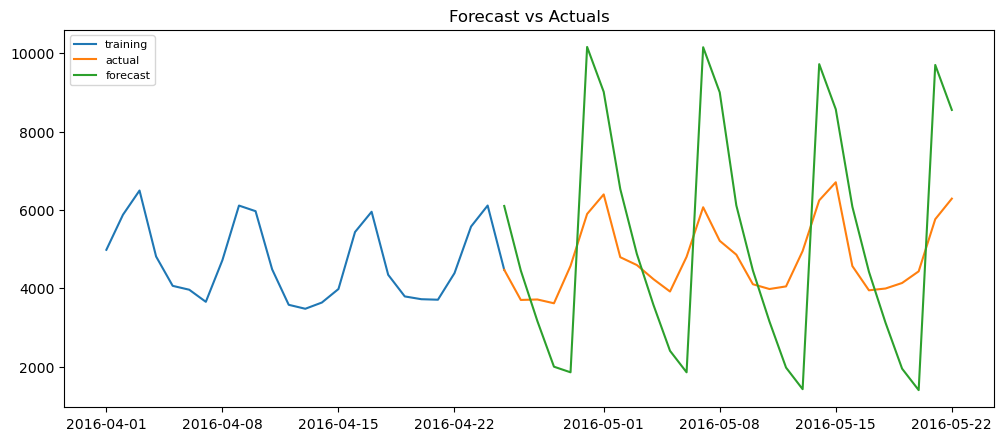

In [218]:
# FB Prophet - BOX-COX

# Make as pandas series with forcasted values
forecast_regs = pd.Series(np.array(forecast_regs["yhat"][-28:]), index=y_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(y_train["2016-04":], label='training')
plt.plot(y_test, label='actual')
plt.plot(forecast_regs, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()